In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
%matplotlib inline
RANDOM_STATE = 42

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [3]:
data = pd.read_csv('winequality-red.csv', sep=';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


1.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [4]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 11), (480, 11), (1119,), (480,))

2.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [5]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
bagger = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                           n_estimators=100,
                           random_state=RANDOM_STATE)
rfc = RandomForestClassifier(random_state=RANDOM_STATE) # по дефолту и так 100 деревьев
tree.fit(X_train, y_train)
bagger.fit(X_train, y_train)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
print(f'Decision tree accuracy: {accuracy_score(y_test, tree.predict(X_test)):.4f}')
print(f'Bagging accuracy: {accuracy_score(y_test, bagger.predict(X_test)):.4f}')
print(f'Random forest accuracy: {accuracy_score(y_test, rfc.predict(X_test)):.4f}')

Decision tree accuracy: 0.5729
Bagging accuracy: 0.6417
Random forest accuracy: 0.6542


### Вывод: 
Обычное дерево решений переобучается, случайный лес и бэггинг более устойчивы к переобучению

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [7]:
counts = [10, 50, 100] + list(range(200, 5001, 200))
accuracies = []
for count in counts:
    model = RandomForestClassifier(n_estimators=count,
                                   random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, model.predict(X_test)))

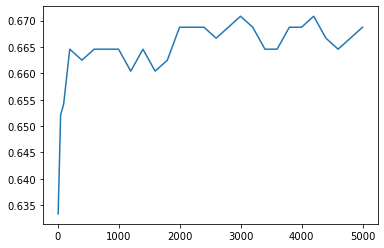

In [8]:
plt.plot(counts, accuracies)

### Вывод:
Как видим качество модели не сильно растет при увеличении количества деревьев. Оптимальным выглядит количество до 500

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [9]:
gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)
xgbc = XGBClassifier(random_state=RANDOM_STATE)

In [10]:
print('Sklearn GB:', np.mean(cross_val_score(gbc, X, y, scoring='accuracy', n_jobs=-1)))

Sklearn GB: 0.5653467868338558


In [11]:
print('XGBoost GB:', np.mean(cross_val_score(xgbc, X, y, scoring='accuracy', n_jobs=-1)))

XGBoost GB: 0.5472335423197492


## Вывод
XGboost работает примерно в 3 раза быстрее, но чуть менее точно

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [12]:
params = {'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'n_estimators': [25, 50, 100, 150, 200],
          'max_depth': [3, 5, 7]
         }
srch_s = GridSearchCV(estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
                      param_grid=params,
                      cv=3,
                      scoring='accuracy',
                      n_jobs=-1)
srch_x = GridSearchCV(estimator=XGBClassifier(random_state=RANDOM_STATE),
                      param_grid=params,
                      cv=3,
                      scoring='accuracy',
                      n_jobs=-1)

In [13]:
srch_s.fit(X, y)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [25, 50, 100, 150, 200]},
             scoring='accuracy')

In [14]:
srch_x.fit(X, y)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [17]:
print('Sklearn GBC:')
print(f'Accuracy: {srch_s.best_score_:.4f}')
print(f'Parameters of a model: {srch_s.best_params_}')

Sklearn GBC:
Accuracy: 0.5685
Parameters of a model: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}


In [18]:
print('XGBoost:')
print(f'Accuracy: {srch_x.best_score_:.4f}')
print(f'Parameters of a model: {srch_x.best_params_}')

XGBoost:
Accuracy: 0.5810
Parameters of a model: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


### Вывод:
Xboost показал чуть более высокий уровень accuracy за время почти в 4 раза быстрее.

6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [19]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [20]:
lgbc = LGBMClassifier(random_state=RANDOM_STATE)
cbc = CatBoostClassifier(random_state=RANDOM_STATE)

In [21]:
print('Light GBM:', np.mean(cross_val_score(lgbc, X, y, scoring='accuracy', n_jobs=-1)))

Light GBM: 0.5572472570532915


In [22]:
print('Catboost Classifier:', np.mean(cross_val_score(cbc, X, y, scoring='accuracy', n_jobs=-1)))

Catboost Classifier: 0.5516105015673981


#### Вывод:
Метрика accuracy примерно такая же как по sklearn и xgboost, но при этом catboost сильно проигрывает по времени: 34 секунд против 6, 2, 4 по sklearn, xgboost и lightgbm соответственно.

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [23]:
srch_l = GridSearchCV(estimator=LGBMClassifier(random_state=RANDOM_STATE),
                      param_grid=params,
                      cv=3,
                      scoring='accuracy',
                      n_jobs=-1)
srch_c = GridSearchCV(estimator=CatBoostClassifier(random_state=RANDOM_STATE),
                      param_grid=params,
                      cv=3,
                      scoring='accuracy',
                      n_jobs=-1)

In [24]:
srch_l.fit(X, y)

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [25, 50, 100, 150, 200]},
             scoring='accuracy')

In [25]:
srch_c.fit(X, y)

0:	learn: 1.5343515	total: 143ms	remaining: 3.42s
1:	learn: 1.3675445	total: 146ms	remaining: 1.68s
2:	learn: 1.2647222	total: 150ms	remaining: 1.1s
3:	learn: 1.1818147	total: 153ms	remaining: 806ms
4:	learn: 1.1219521	total: 158ms	remaining: 631ms
5:	learn: 1.0773894	total: 161ms	remaining: 510ms
6:	learn: 1.0424289	total: 165ms	remaining: 424ms
7:	learn: 1.0095036	total: 168ms	remaining: 357ms
8:	learn: 0.9833135	total: 172ms	remaining: 306ms
9:	learn: 0.9593808	total: 176ms	remaining: 263ms
10:	learn: 0.9413361	total: 179ms	remaining: 228ms
11:	learn: 0.9290779	total: 183ms	remaining: 198ms
12:	learn: 0.9181650	total: 186ms	remaining: 172ms
13:	learn: 0.9041588	total: 190ms	remaining: 149ms
14:	learn: 0.8925624	total: 193ms	remaining: 129ms
15:	learn: 0.8825740	total: 197ms	remaining: 111ms
16:	learn: 0.8730461	total: 200ms	remaining: 94.1ms
17:	learn: 0.8645670	total: 205ms	remaining: 79.6ms
18:	learn: 0.8552018	total: 208ms	remaining: 65.8ms
19:	learn: 0.8509818	total: 212ms	remai

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001CD7FF20AF0>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [25, 50, 100, 150, 200]},
             scoring='accuracy')

In [53]:
print('Light GBM:')
print(f'Accuracy: {srch_l.best_score_:.4f}')
print(f'Parameters of a model: {srch_l.best_params_}')

Light GBM:
Accuracy: 0.5741
Parameters of a model: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [52]:
print('CatBoost:')
print(f'Accuracy: {srch_c.best_score_:.4f}')
print(f'Parameters of a model: {srch_c.best_params_}')

CatBoost:
Accuracy: 0.5941
Parameters of a model: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 25}


### Вывод:
По accuracy различные библиотеки примерно похожи: от 0.568 для sklearn до 0.594 для Catboost.<br>
По скорости самой медленной оказалась библиотека sklearn: 5 минут, следующая - это catboost: 2.5 минуты, потом xgboost: 1 минута и, наконец, самая быстрая lightgbm: 23 секунты.<br>
Также интересно, что у разных библиотек разные оптимальные гиперпараметры.

8.Подберите оптимальные параметры алгоритма из библиотеки xgboost с помощью [optuna](https://github.com/optuna/optuna). Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [29]:
import optuna

In [43]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params


def xgboost_objective(trial):
    _n_estimators = trial.suggest_int('n_estimators', 25, 200)
    _max_depth = trial.suggest_int('max_depth', 3, 7)
    _learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    xgbc = XGBClassifier(
        max_depth=_max_depth,
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    scores = cross_val_score(xgbc, X, y, cv=3, scoring='accuracy')
    return scores.mean()

In [44]:
best_params = tune(xgboost_objective)

[I 2022-10-30 19:29:06,467] A new study created in memory with name: no-name-a5740dbe-0b2b-4934-aa6a-bdb129ac73bb


Best score: 0.5828642901813633

Optimized parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.029133304985151664}



### Вывод:
Optuna сама подбирает подходящие гиперпараметры, заданные в определенных пределах, а не просто идет по сетке как в Grid Search. Результат accuracy на хорошем уровне как и в других оптимизациях.

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [36]:
from sklearn.ensemble import StackingClassifier

In [41]:
estimators = [
    ('gbc', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('xgbc', XGBClassifier(random_state=RANDOM_STATE)),
    ('lgbc', LGBMClassifier(random_state=RANDOM_STATE)),
    ('cbc', CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'))
]
clf = StackingClassifier(estimators=estimators)

In [45]:
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('gbc',
                                GradientBoostingClassifier(random_state=42)),
                               ('xgbc',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              inte...
                                              max_cat_to_onehot=None,
     

In [47]:
print(f'Stacking accuracy: {clf.score(X_test, y_test):.4f}')

Stacking accuracy: 0.6771


10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [49]:
best_estimators = [
    ('gbc', GradientBoostingClassifier(**srch_s.best_params_, random_state=RANDOM_STATE)),
    ('xgbc', XGBClassifier(**srch_x.best_params_, random_state=RANDOM_STATE)),
    ('lgbc', LGBMClassifier(**srch_l.best_params_, random_state=RANDOM_STATE)),
    ('cbc', CatBoostClassifier(**srch_c.best_params_, random_state=RANDOM_STATE, 
                               logging_level='Silent'))
]
best_clf = StackingClassifier(estimators=best_estimators)

In [50]:
best_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('gbc',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           n_estimators=150,
                                                           random_state=42)),
                               ('xgbc',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_p...
                                              max

In [51]:
print(f'Stacking accuracy: {best_clf.score(X_test, y_test):.4f}')

Stacking accuracy: 0.5729


### Вывод:
Удивительно, но стэкинг моделей с лучшими параметрами дал значительное снижение accuracy, возможно причина в излишнем переобучении моделей.